# Subtitle detection from photo

## 이미지 불러오기

Image Size: Width = 2559px, Height = 1410px, Channels = 3


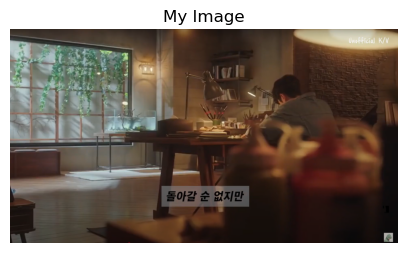

In [1]:
import cv2
from matplotlib import pyplot as plt
import matplotlib.patches as patches

# 이미지 불러오기 및 RGB 변환
image = cv2.imread('./photo2.png')
if image is None:
    print("There is no image")
else:
    height, width, channels = image.shape
    print(f"Image Size: Width = {width}px, Height = {height}px, Channels = {channels}")

    # BGR → RGB 변환
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(5, 5))
    plt.imshow(image_rgb)
    plt.title('My Image')
    plt.axis('off')
    plt.show()

## Crop 영역 지정

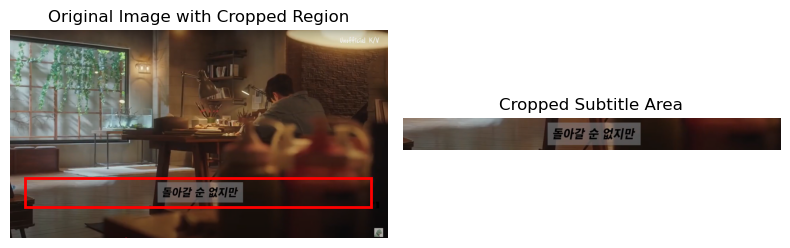

In [2]:
# Crop 영역 지정 (왼쪽 위 기준)
top = 1000
bottom = 1200
left = 100
right = 2450
crop_width = right - left
crop_height = bottom - top

# crop된 이미지
cropped_image = image_rgb[top:bottom, left:right]

# 두 개의 subplot 생성 (1행 2열)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# 왼쪽: 원본 + 사각형
ax1.imshow(image_rgb)
rect = patches.Rectangle((left, top), crop_width, crop_height,
                            linewidth=2, edgecolor='red', facecolor='none')
ax1.add_patch(rect)
ax1.set_title("Original Image with Cropped Region")
ax1.axis('off')

# 오른쪽: crop된 이미지
ax2.imshow(cropped_image)
ax2.set_title("Cropped Subtitle Area")
ax2.axis('off')

plt.tight_layout()
plt.show()

## 자막 인식 - 1

Target Color (RGB): [4 0 0]


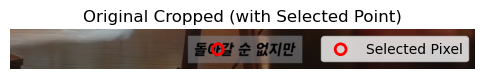

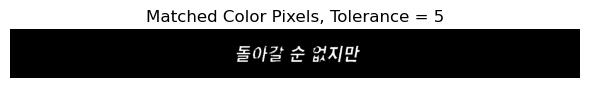

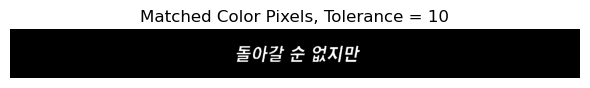

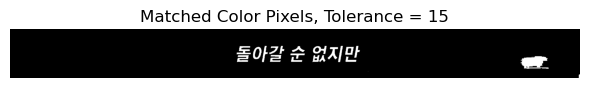

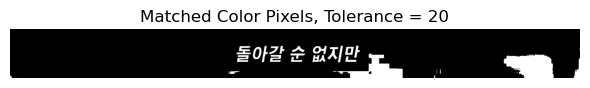

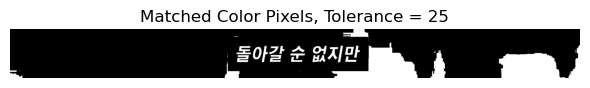

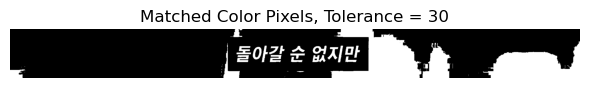

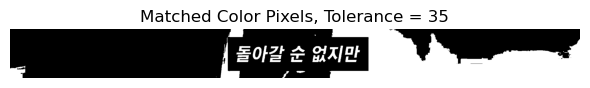

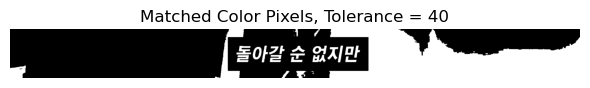

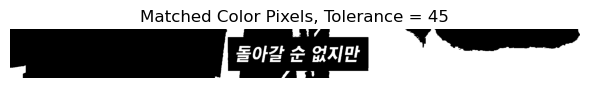

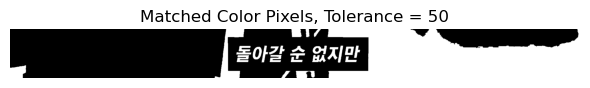

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# 예시 위치
y, x = 100, 1050
target_color = cropped_image[y, x]  # RGB 형식
print(f"Target Color (RGB): {target_color}")

# 첫 번째 플롯: 원본 크롭 이미지 + 점 표시
plt.figure(figsize=(6, 5))
plt.imshow(cropped_image)
plt.scatter(x, y, s=60, facecolors='none', edgecolors='red', linewidths=2, marker='o', label='Selected Pixel')
plt.title("Original Cropped (with Selected Point)")
plt.axis('off')
plt.legend(loc='upper right')

# tolerance 적용해서 범위 정의
highlighted_image_results = []  # 결과 저장 리스트
tolerances = list(range(5, 51, 5))
for tolerance in tolerances:
    lower = np.array([max(0, c - tolerance) for c in target_color])
    upper = np.array([min(255, c + tolerance) for c in target_color])

    # BGR 변환 및 마스크 생성
    cropped_bgr = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR)
    lower_bgr = np.array([lower[2], lower[1], lower[0]])
    upper_bgr = np.array([upper[2], upper[1], upper[0]])
    mask = cv2.inRange(cropped_bgr, lower_bgr, upper_bgr)
    result = cv2.bitwise_and(cropped_image, cropped_image, mask=mask)

    # 3. 빨간색으로 칠한 이미지 만들기
    highlighted_image = np.full_like(cropped_image, 0)  # 전체 검은 배경
    highlighted_image[mask == 255] = [255, 255, 255]

    highlighted_image_results.append({
        "tolerance": tolerance,
        "highlighted_image": highlighted_image.copy(),
        "mask": mask.copy(),
        "white_pixel_count": np.sum(mask == 255)
    })

# ✅ 시각화: for문 바깥에서 일괄 출력
for result in highlighted_image_results:
    plt.figure(figsize=(6, 5))
    plt.imshow(result["highlighted_image"])
    plt.title(f"Matched Color Pixels, Tolerance = {result["tolerance"]}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

## 자막 인식 - 2


🔎 PSM: psm6, Conf Threshold: 0, Tolerance = 5
0: '줄' (conf: 46)
1: '아' (conf: 93)
2: '갈' (conf: 93)
3: '순' (conf: 92)
4: '없지만' (conf: 95)


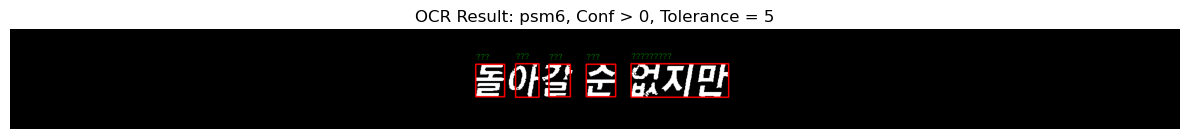


🔎 PSM: psm8, Conf Threshold: 0, Tolerance = 5
0: 'x' (conf: 62)
1: 'gia]' (conf: 43)
2: 'Ft' (conf: 32)


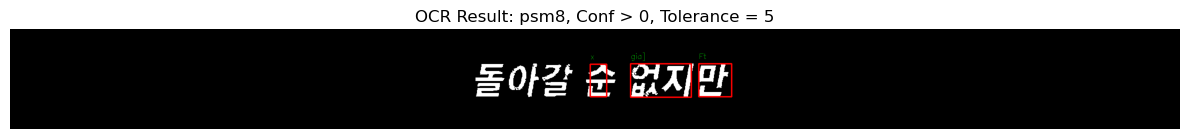


🔎 PSM: psm10, Conf Threshold: 0, Tolerance = 5
0: '줄' (conf: 46)
1: '아' (conf: 93)
2: '갈' (conf: 93)
3: '순' (conf: 92)
4: '없지만' (conf: 95)


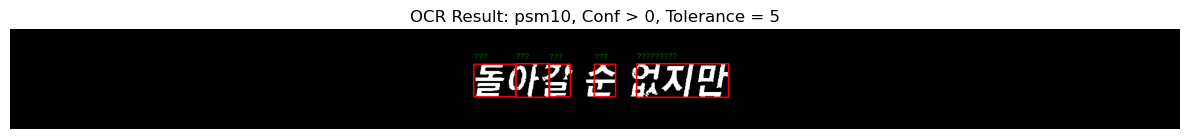


🔎 PSM: psm6, Conf Threshold: 10, Tolerance = 5
0: '줄' (conf: 46)
1: '아' (conf: 93)
2: '갈' (conf: 93)
3: '순' (conf: 92)
4: '없지만' (conf: 95)


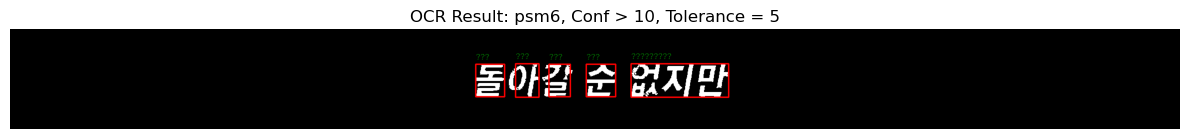


🔎 PSM: psm8, Conf Threshold: 10, Tolerance = 5
0: 'x' (conf: 62)
1: 'gia]' (conf: 43)
2: 'Ft' (conf: 32)


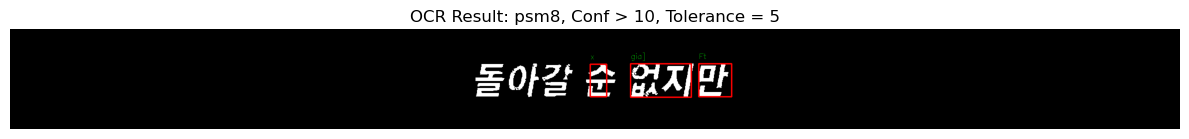


🔎 PSM: psm10, Conf Threshold: 10, Tolerance = 5
0: '줄' (conf: 46)
1: '아' (conf: 93)
2: '갈' (conf: 93)
3: '순' (conf: 92)
4: '없지만' (conf: 95)


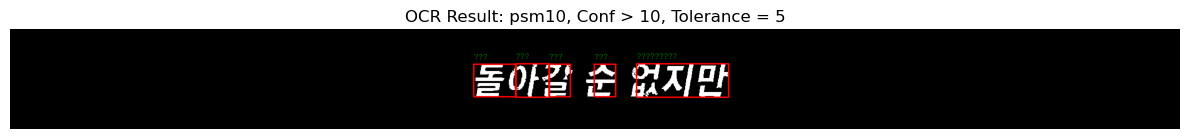


🔎 PSM: psm6, Conf Threshold: 50, Tolerance = 5
0: '아' (conf: 93)
1: '갈' (conf: 93)
2: '순' (conf: 92)
3: '없지만' (conf: 95)


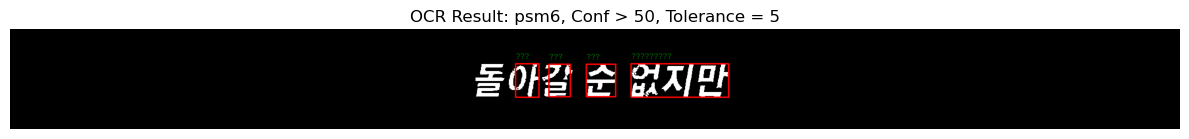


🔎 PSM: psm8, Conf Threshold: 50, Tolerance = 5
0: 'x' (conf: 62)


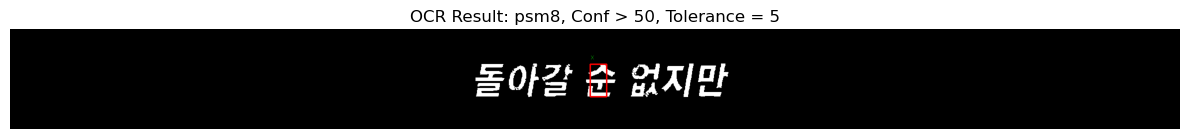


🔎 PSM: psm10, Conf Threshold: 50, Tolerance = 5
0: '아' (conf: 93)
1: '갈' (conf: 93)
2: '순' (conf: 92)
3: '없지만' (conf: 95)


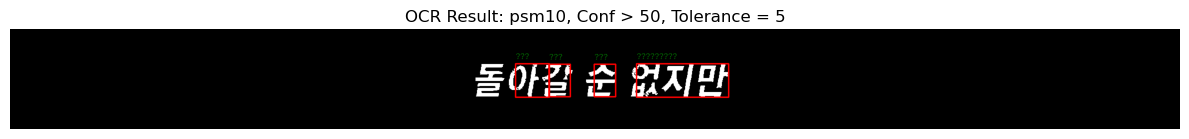


🔎 PSM: psm6, Conf Threshold: 0, Tolerance = 10
0: '줄' (conf: 66)
1: '아' (conf: 91)
2: '갈' (conf: 93)
3: '순' (conf: 92)
4: '없지만' (conf: 95)


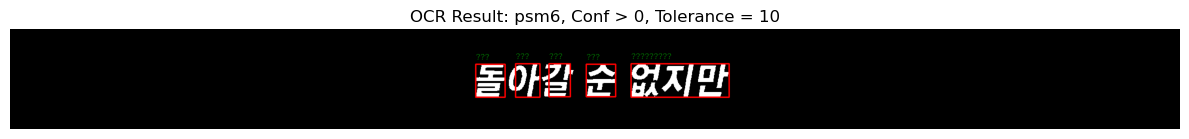


🔎 PSM: psm8, Conf Threshold: 0, Tolerance = 10
0: 'ZOE' (conf: 14)
1: '=' (conf: 46)


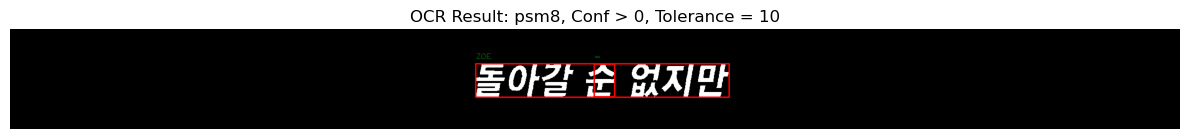


🔎 PSM: psm10, Conf Threshold: 0, Tolerance = 10
0: '줄' (conf: 66)
1: '아' (conf: 91)
2: '갈' (conf: 93)
3: '순' (conf: 92)
4: '없지만' (conf: 95)


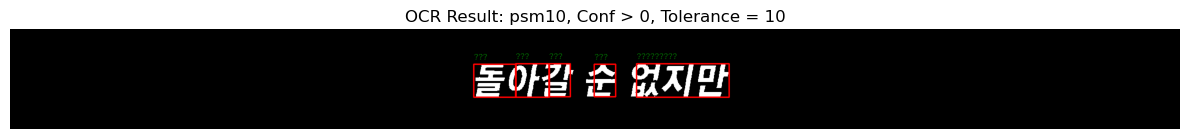


🔎 PSM: psm6, Conf Threshold: 10, Tolerance = 10
0: '줄' (conf: 66)
1: '아' (conf: 91)
2: '갈' (conf: 93)
3: '순' (conf: 92)
4: '없지만' (conf: 95)


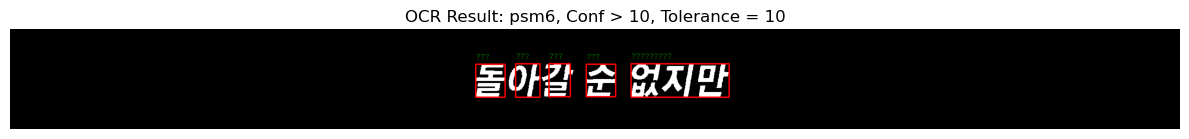


🔎 PSM: psm8, Conf Threshold: 10, Tolerance = 10
0: 'ZOE' (conf: 14)
1: '=' (conf: 46)


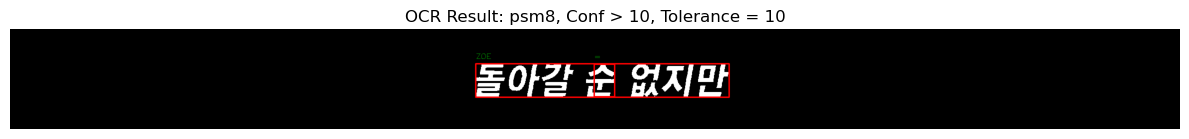


🔎 PSM: psm10, Conf Threshold: 10, Tolerance = 10
0: '줄' (conf: 66)
1: '아' (conf: 91)
2: '갈' (conf: 93)
3: '순' (conf: 92)
4: '없지만' (conf: 95)


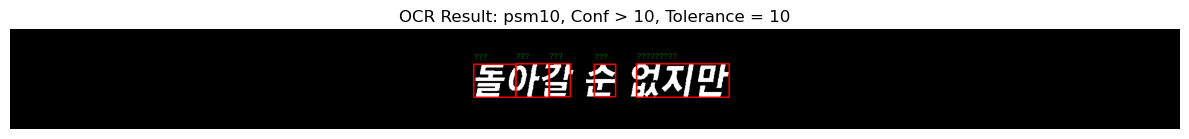


🔎 PSM: psm6, Conf Threshold: 50, Tolerance = 10
0: '줄' (conf: 66)
1: '아' (conf: 91)
2: '갈' (conf: 93)
3: '순' (conf: 92)
4: '없지만' (conf: 95)


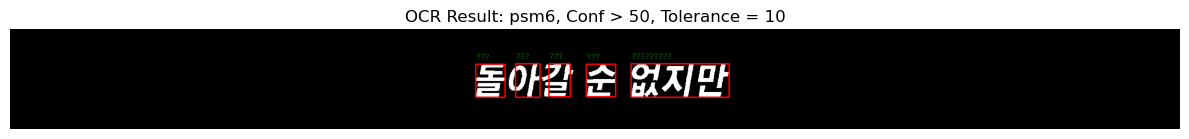


🔎 PSM: psm8, Conf Threshold: 50, Tolerance = 10


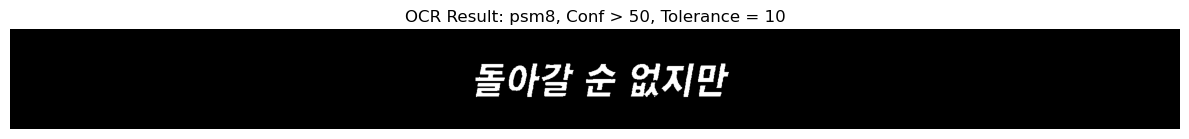


🔎 PSM: psm10, Conf Threshold: 50, Tolerance = 10
0: '줄' (conf: 66)
1: '아' (conf: 91)
2: '갈' (conf: 93)
3: '순' (conf: 92)
4: '없지만' (conf: 95)


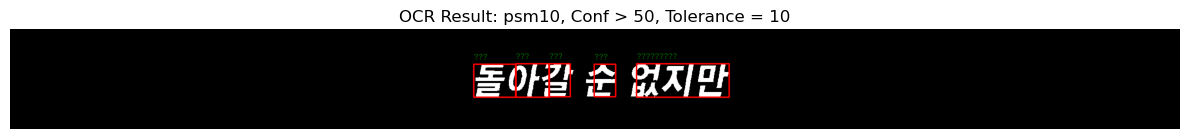


🔎 PSM: psm6, Conf Threshold: 0, Tolerance = 15
0: '돌' (conf: 89)
1: '야' (conf: 87)
2: '갈' (conf: 93)
3: '순' (conf: 93)
4: '없지만' (conf: 93)
5: '_' (conf: 30)


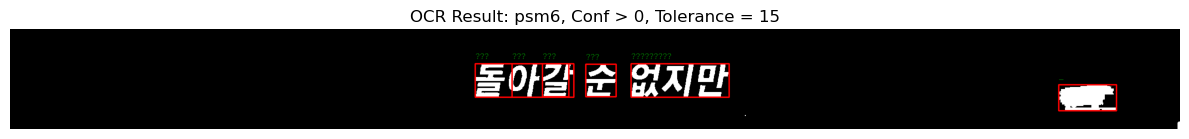


🔎 PSM: psm8, Conf Threshold: 0, Tolerance = 15


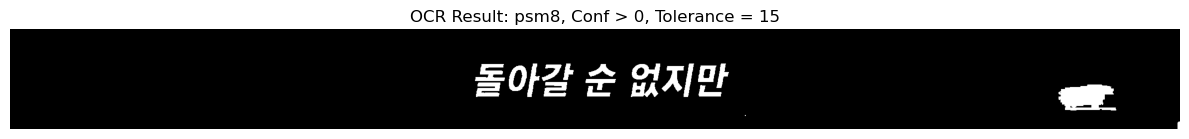


🔎 PSM: psm10, Conf Threshold: 0, Tolerance = 15


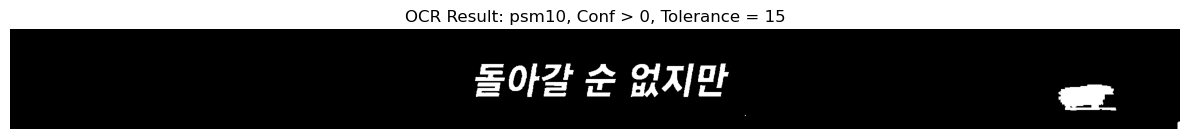


🔎 PSM: psm6, Conf Threshold: 10, Tolerance = 15
0: '돌' (conf: 89)
1: '야' (conf: 87)
2: '갈' (conf: 93)
3: '순' (conf: 93)
4: '없지만' (conf: 93)
5: '_' (conf: 30)


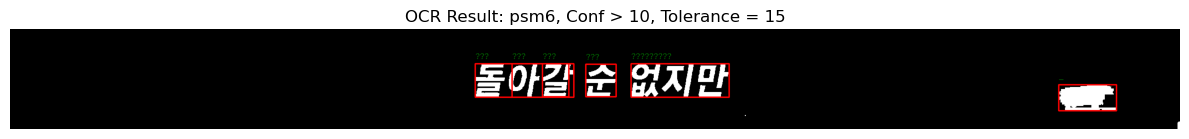


🔎 PSM: psm8, Conf Threshold: 10, Tolerance = 15


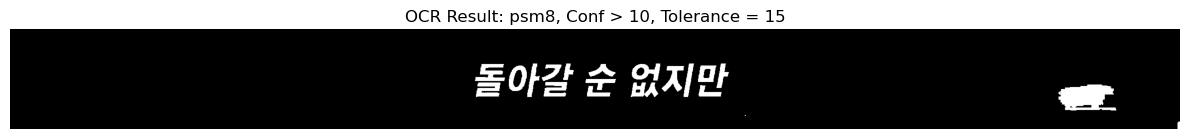


🔎 PSM: psm10, Conf Threshold: 10, Tolerance = 15


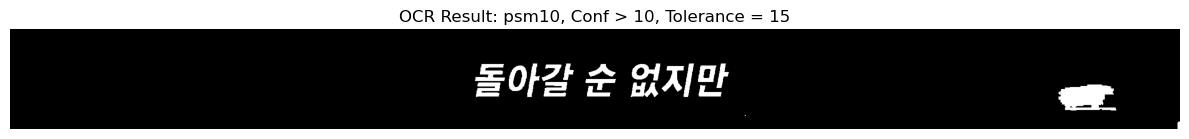


🔎 PSM: psm6, Conf Threshold: 50, Tolerance = 15
0: '돌' (conf: 89)
1: '야' (conf: 87)
2: '갈' (conf: 93)
3: '순' (conf: 93)
4: '없지만' (conf: 93)


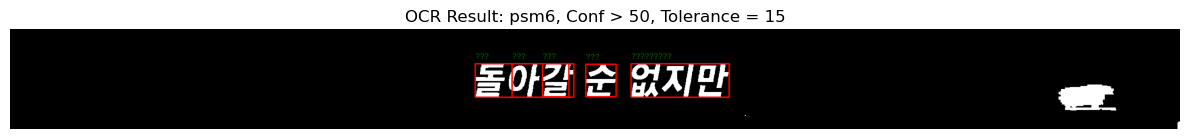


🔎 PSM: psm8, Conf Threshold: 50, Tolerance = 15


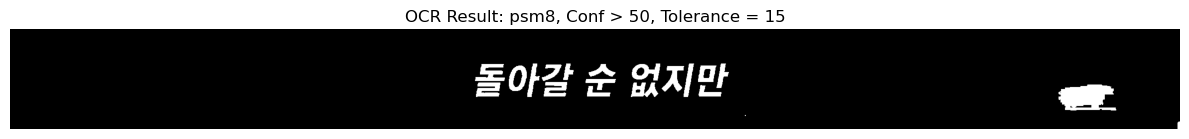


🔎 PSM: psm10, Conf Threshold: 50, Tolerance = 15


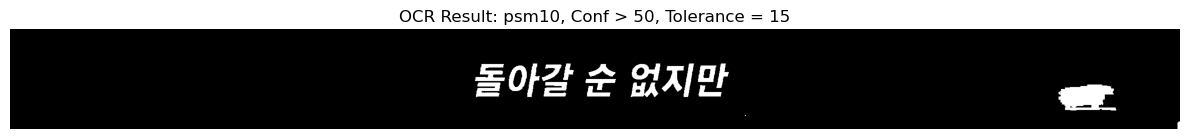


🔎 PSM: psm6, Conf Threshold: 0, Tolerance = 20
0: 'Bore' (conf: 49)
1: '순' (conf: 88)
2: '없지만' (conf: 90)


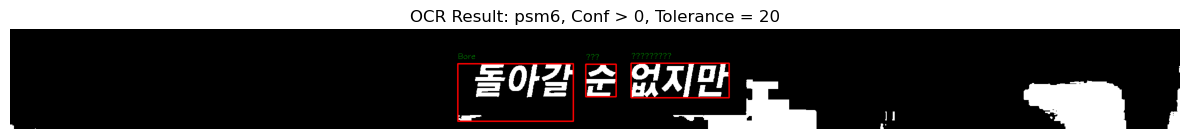


🔎 PSM: psm8, Conf Threshold: 0, Tolerance = 20


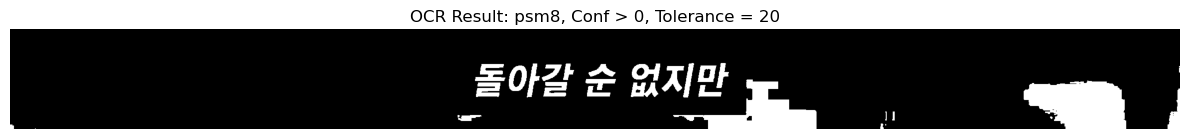


🔎 PSM: psm10, Conf Threshold: 0, Tolerance = 20


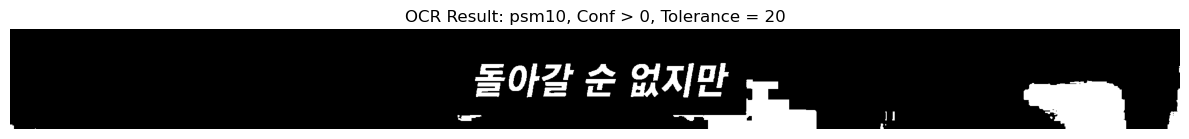


🔎 PSM: psm6, Conf Threshold: 10, Tolerance = 20
0: 'Bore' (conf: 49)
1: '순' (conf: 88)
2: '없지만' (conf: 90)


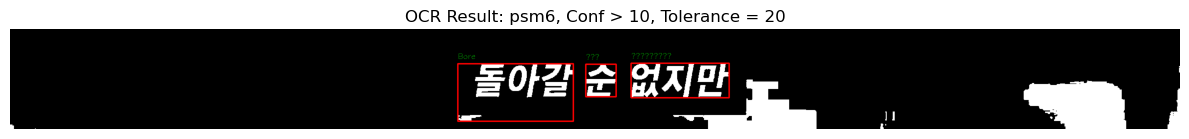


🔎 PSM: psm8, Conf Threshold: 10, Tolerance = 20


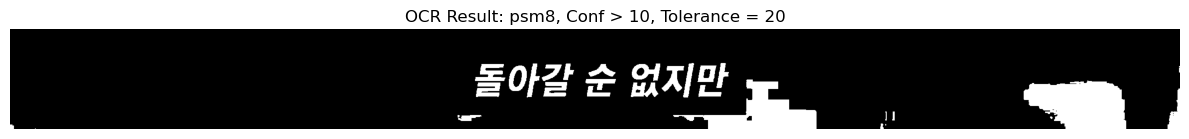


🔎 PSM: psm10, Conf Threshold: 10, Tolerance = 20


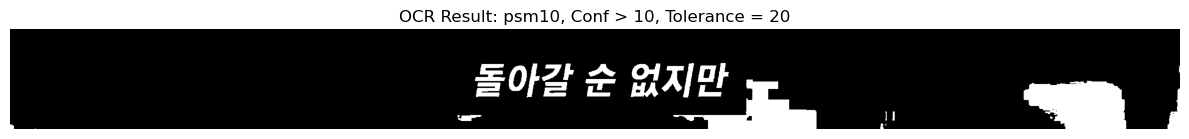


🔎 PSM: psm6, Conf Threshold: 50, Tolerance = 20
0: '순' (conf: 88)
1: '없지만' (conf: 90)


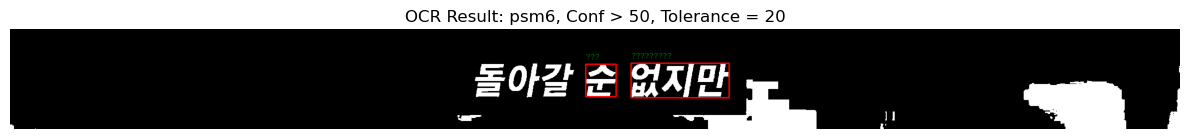


🔎 PSM: psm8, Conf Threshold: 50, Tolerance = 20


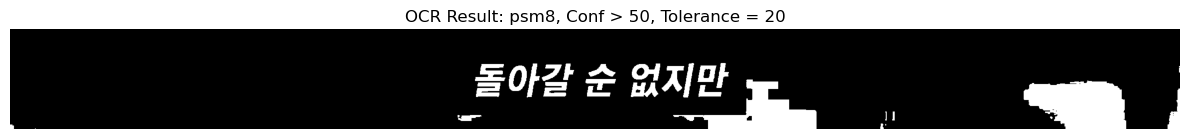


🔎 PSM: psm10, Conf Threshold: 50, Tolerance = 20


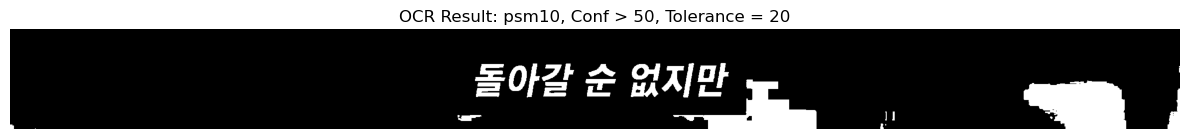


🔎 PSM: psm6, Conf Threshold: 0, Tolerance = 25


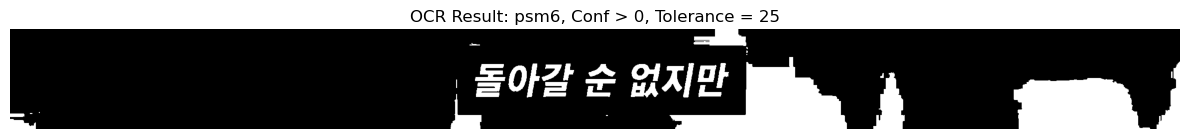


🔎 PSM: psm8, Conf Threshold: 0, Tolerance = 25


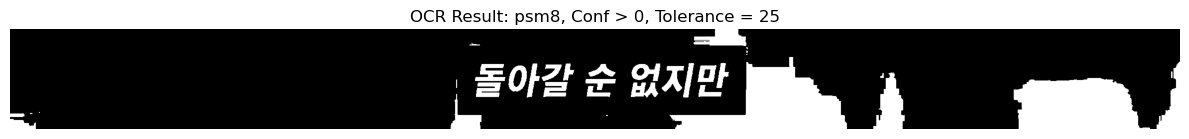


🔎 PSM: psm10, Conf Threshold: 0, Tolerance = 25


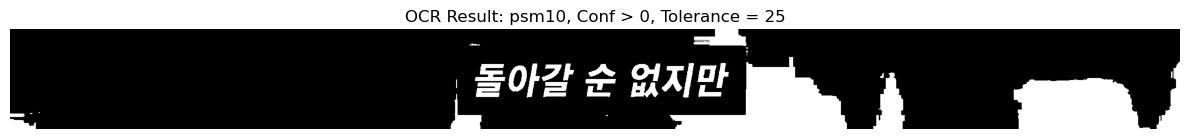


🔎 PSM: psm6, Conf Threshold: 10, Tolerance = 25


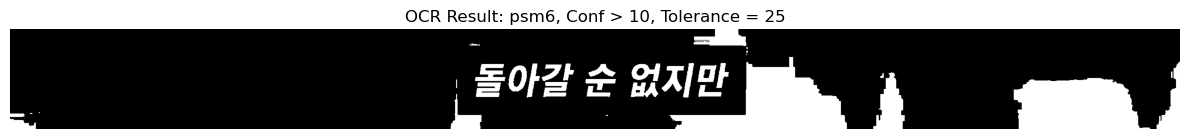


🔎 PSM: psm8, Conf Threshold: 10, Tolerance = 25


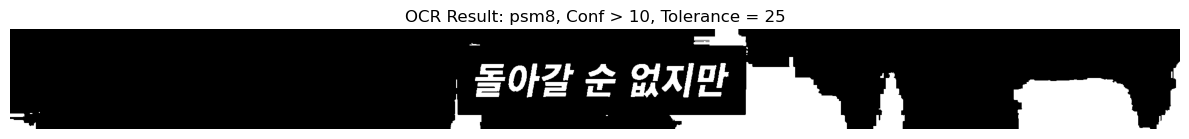


🔎 PSM: psm10, Conf Threshold: 10, Tolerance = 25


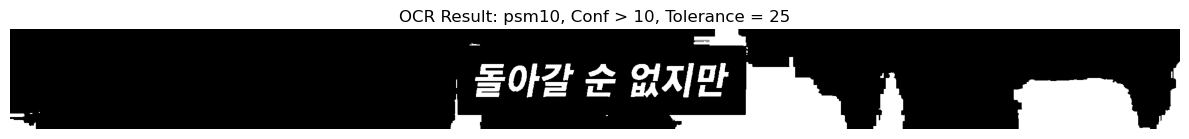


🔎 PSM: psm6, Conf Threshold: 50, Tolerance = 25


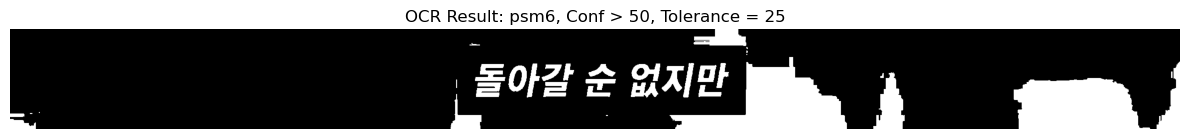


🔎 PSM: psm8, Conf Threshold: 50, Tolerance = 25


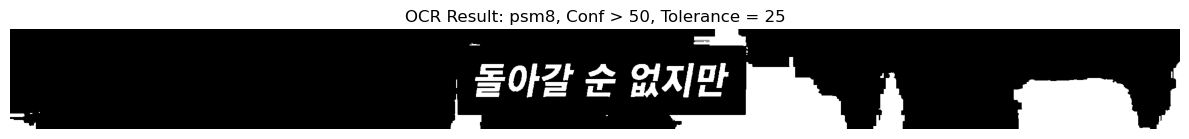


🔎 PSM: psm10, Conf Threshold: 50, Tolerance = 25


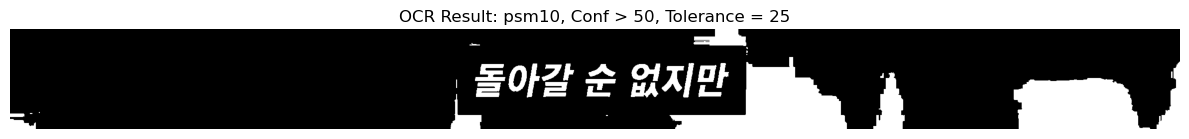


🔎 PSM: psm6, Conf Threshold: 0, Tolerance = 30


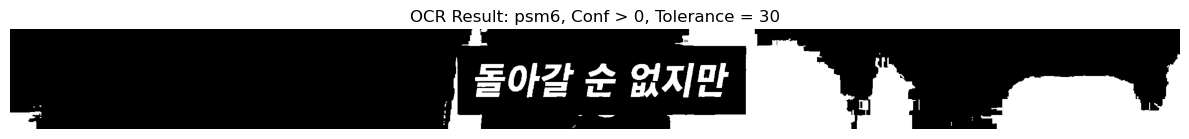


🔎 PSM: psm8, Conf Threshold: 0, Tolerance = 30


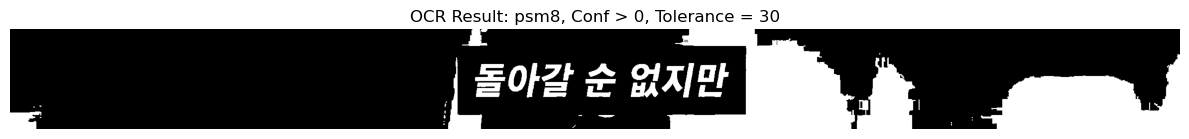


🔎 PSM: psm10, Conf Threshold: 0, Tolerance = 30


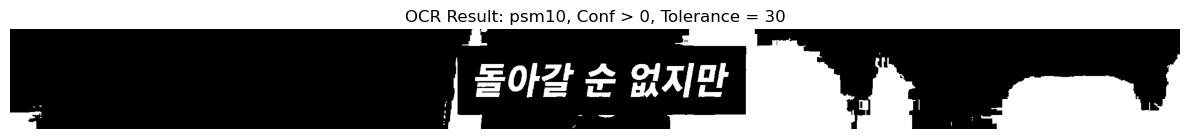


🔎 PSM: psm6, Conf Threshold: 10, Tolerance = 30


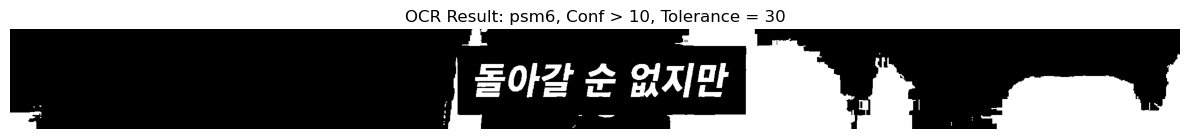


🔎 PSM: psm8, Conf Threshold: 10, Tolerance = 30


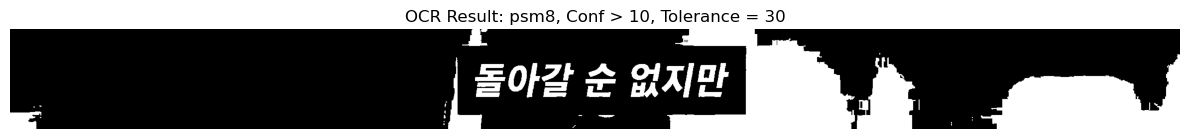


🔎 PSM: psm10, Conf Threshold: 10, Tolerance = 30


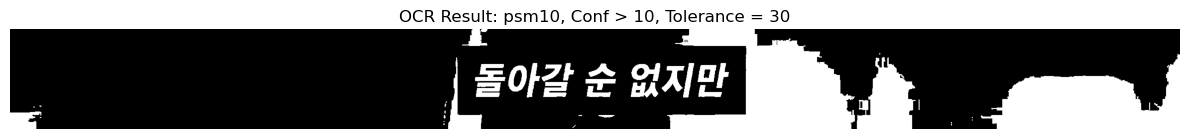


🔎 PSM: psm6, Conf Threshold: 50, Tolerance = 30


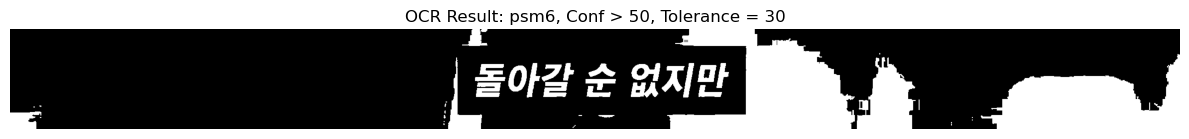


🔎 PSM: psm8, Conf Threshold: 50, Tolerance = 30


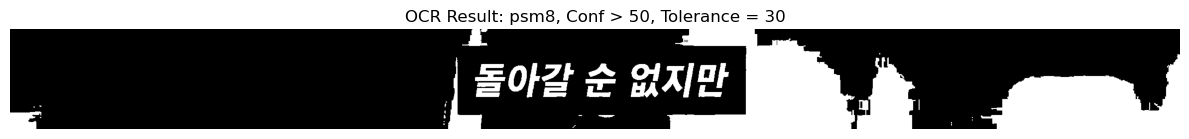


🔎 PSM: psm10, Conf Threshold: 50, Tolerance = 30


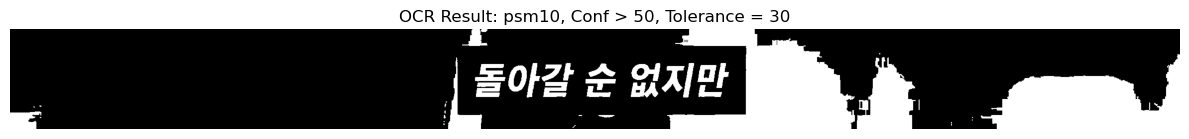


🔎 PSM: psm6, Conf Threshold: 0, Tolerance = 35
0: '.' (conf: 29)
1: '|' (conf: 56)


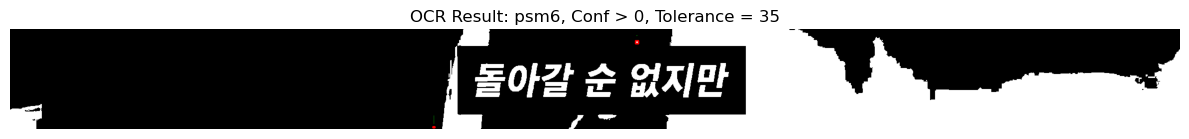


🔎 PSM: psm8, Conf Threshold: 0, Tolerance = 35


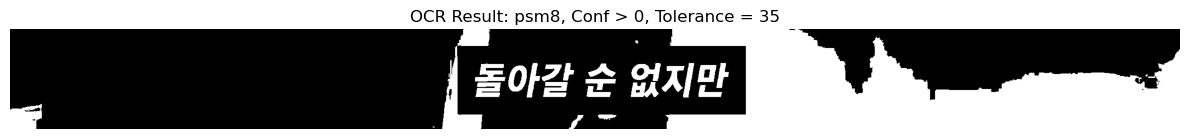


🔎 PSM: psm10, Conf Threshold: 0, Tolerance = 35


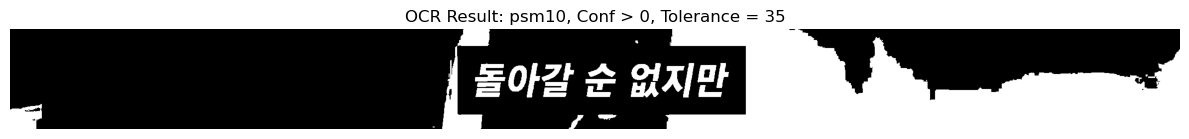


🔎 PSM: psm6, Conf Threshold: 10, Tolerance = 35
0: '.' (conf: 29)
1: '|' (conf: 56)


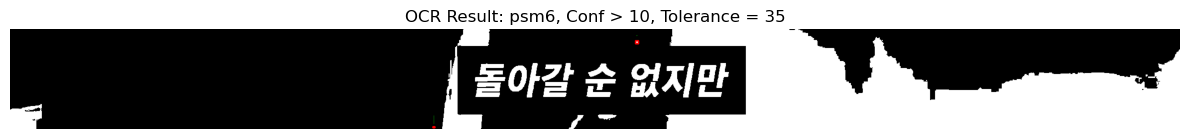


🔎 PSM: psm8, Conf Threshold: 10, Tolerance = 35


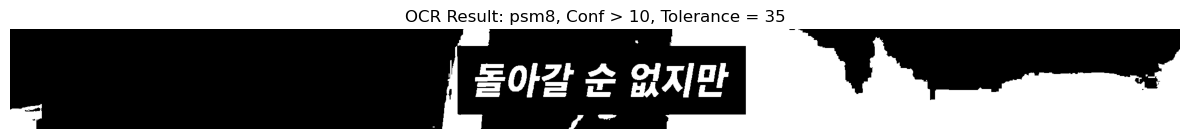


🔎 PSM: psm10, Conf Threshold: 10, Tolerance = 35


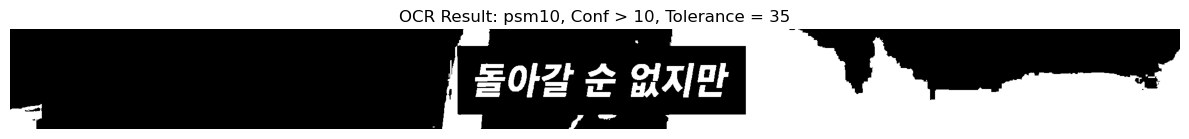


🔎 PSM: psm6, Conf Threshold: 50, Tolerance = 35
0: '|' (conf: 56)


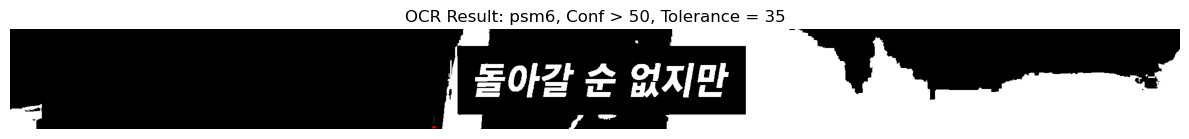


🔎 PSM: psm8, Conf Threshold: 50, Tolerance = 35


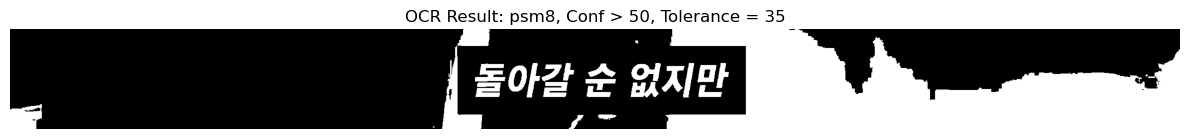


🔎 PSM: psm10, Conf Threshold: 50, Tolerance = 35


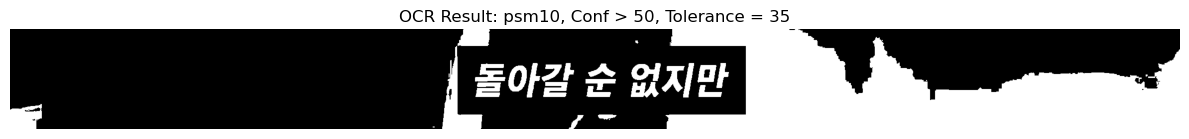


🔎 PSM: psm6, Conf Threshold: 0, Tolerance = 40


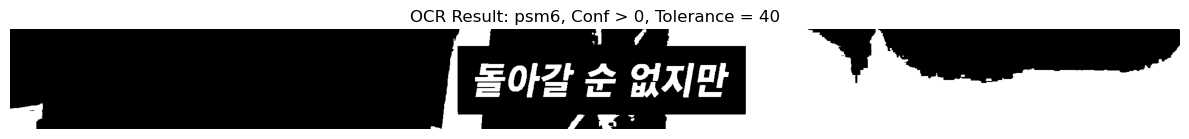


🔎 PSM: psm8, Conf Threshold: 0, Tolerance = 40


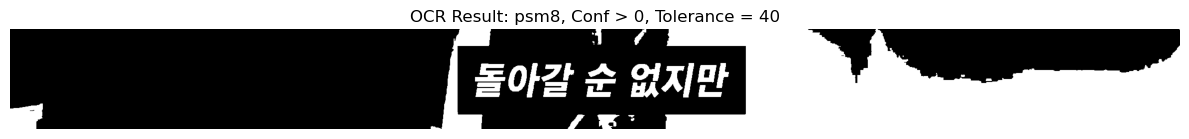


🔎 PSM: psm10, Conf Threshold: 0, Tolerance = 40


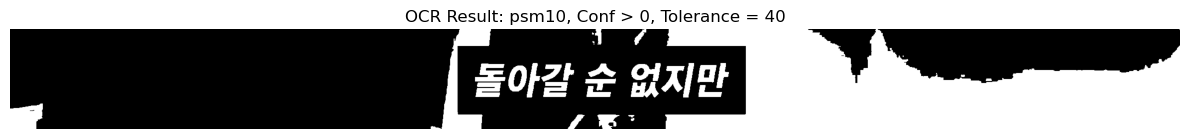


🔎 PSM: psm6, Conf Threshold: 10, Tolerance = 40


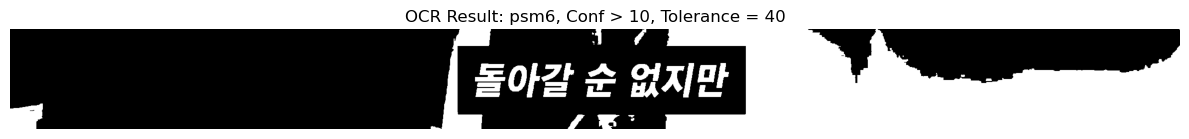


🔎 PSM: psm8, Conf Threshold: 10, Tolerance = 40


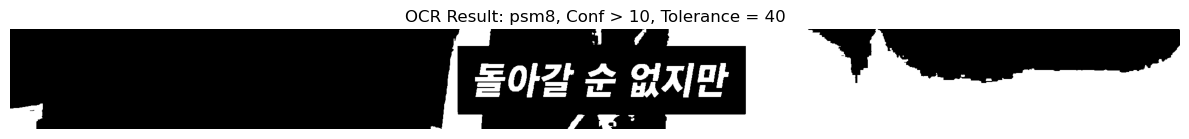


🔎 PSM: psm10, Conf Threshold: 10, Tolerance = 40


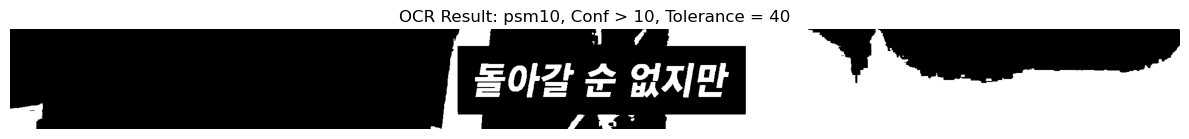


🔎 PSM: psm6, Conf Threshold: 50, Tolerance = 40


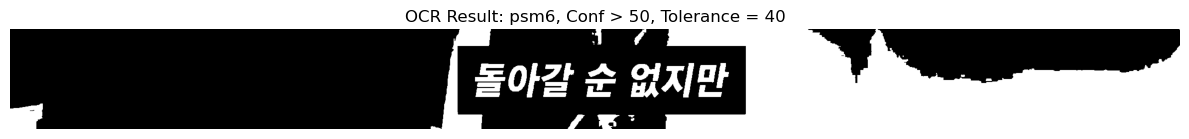


🔎 PSM: psm8, Conf Threshold: 50, Tolerance = 40


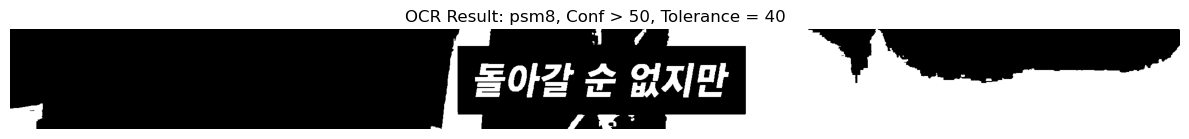


🔎 PSM: psm10, Conf Threshold: 50, Tolerance = 40


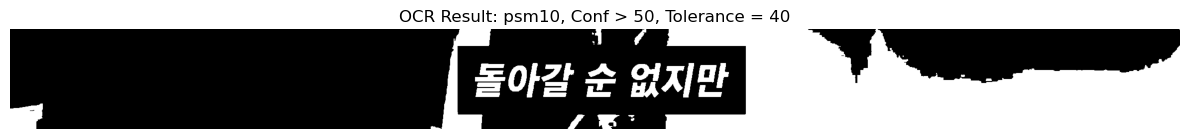


🔎 PSM: psm6, Conf Threshold: 0, Tolerance = 45
0: '|' (conf: 41)


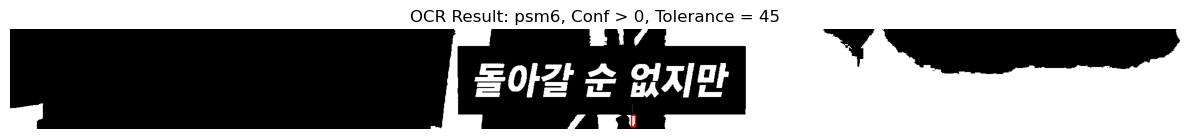


🔎 PSM: psm8, Conf Threshold: 0, Tolerance = 45


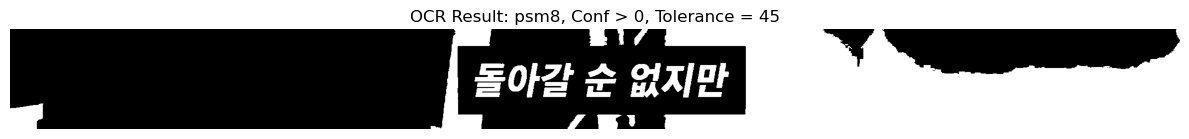


🔎 PSM: psm10, Conf Threshold: 0, Tolerance = 45


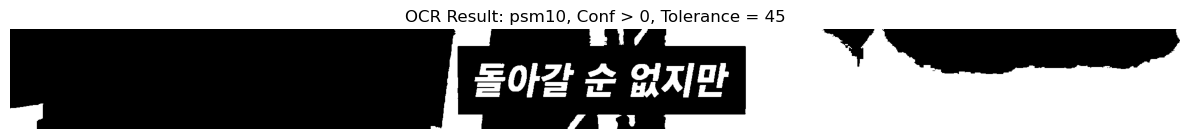


🔎 PSM: psm6, Conf Threshold: 10, Tolerance = 45
0: '|' (conf: 41)


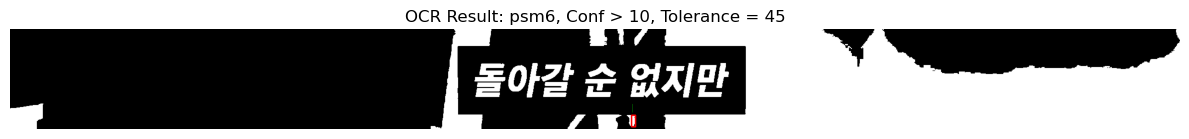


🔎 PSM: psm8, Conf Threshold: 10, Tolerance = 45


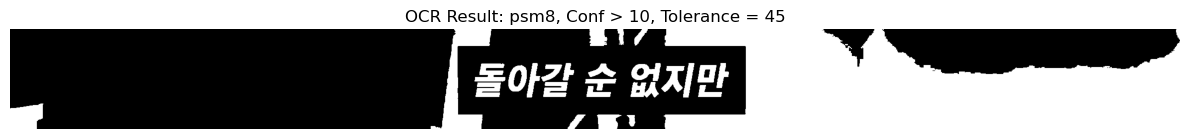


🔎 PSM: psm10, Conf Threshold: 10, Tolerance = 45


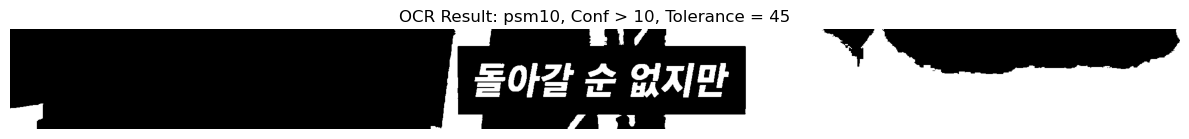


🔎 PSM: psm6, Conf Threshold: 50, Tolerance = 45


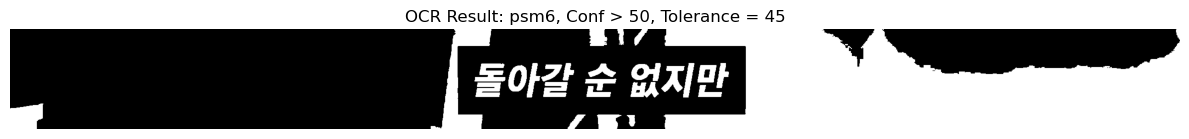


🔎 PSM: psm8, Conf Threshold: 50, Tolerance = 45


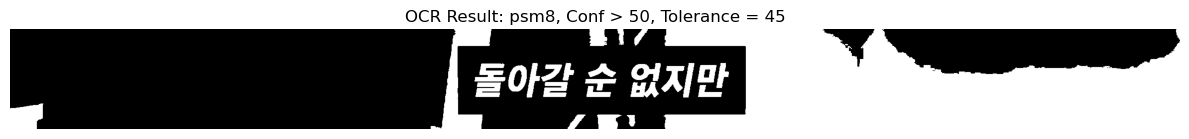


🔎 PSM: psm10, Conf Threshold: 50, Tolerance = 45


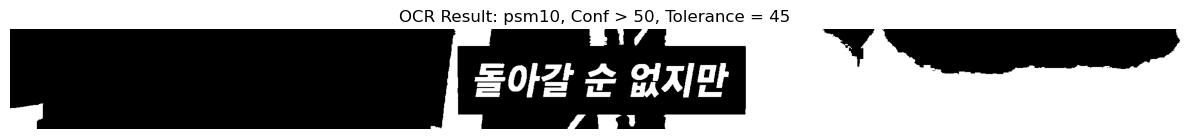


🔎 PSM: psm6, Conf Threshold: 0, Tolerance = 50


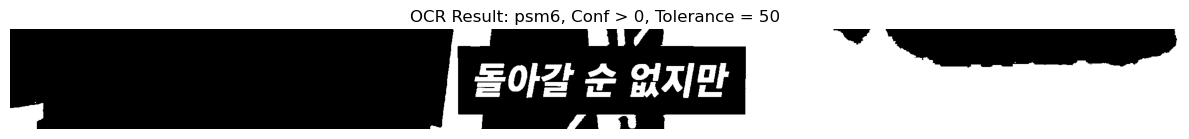


🔎 PSM: psm8, Conf Threshold: 0, Tolerance = 50


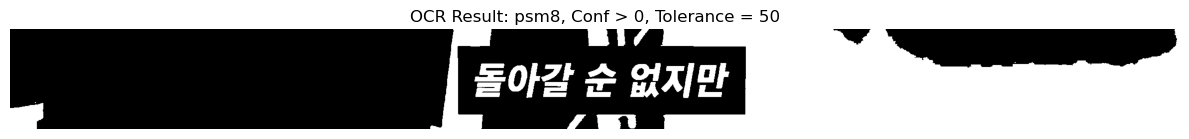


🔎 PSM: psm10, Conf Threshold: 0, Tolerance = 50


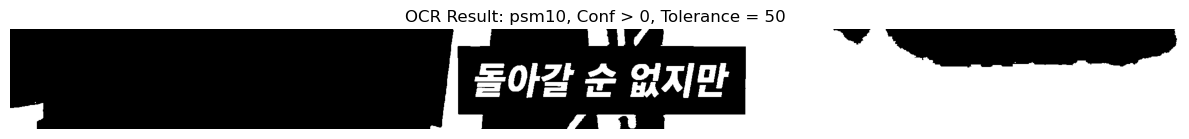


🔎 PSM: psm6, Conf Threshold: 10, Tolerance = 50


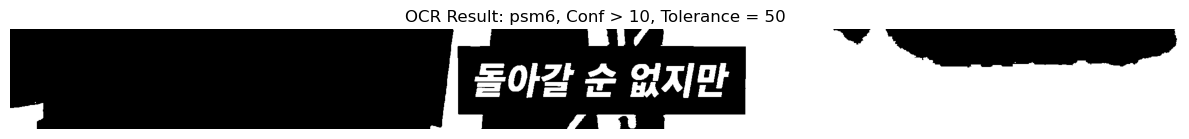


🔎 PSM: psm8, Conf Threshold: 10, Tolerance = 50


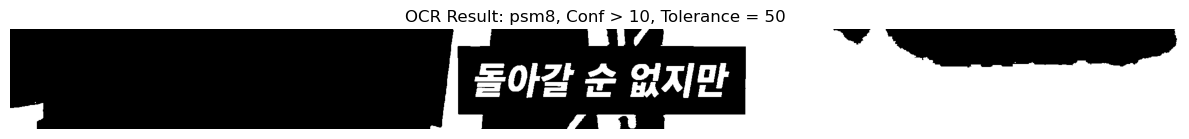


🔎 PSM: psm10, Conf Threshold: 10, Tolerance = 50


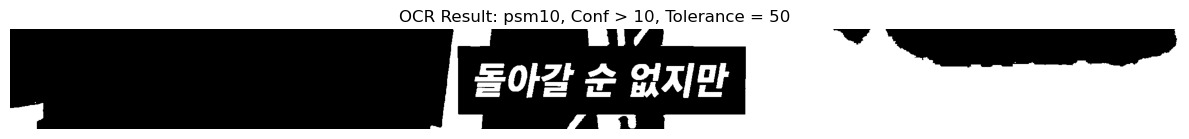


🔎 PSM: psm6, Conf Threshold: 50, Tolerance = 50


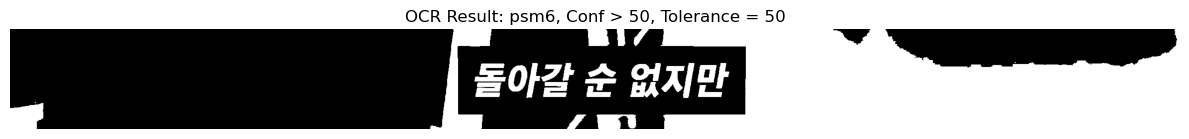


🔎 PSM: psm8, Conf Threshold: 50, Tolerance = 50


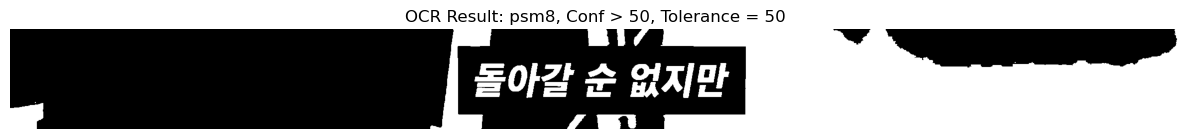


🔎 PSM: psm10, Conf Threshold: 50, Tolerance = 50


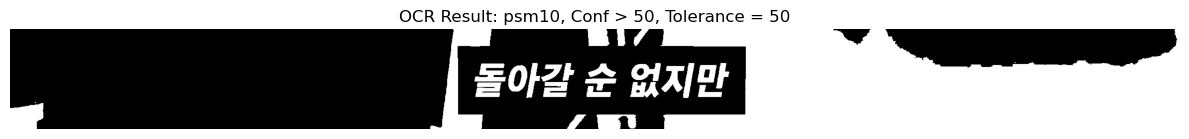

In [41]:
import cv2
import pytesseract
from pytesseract import Output
import matplotlib.pyplot as plt
import numpy as np

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

conf_thresholds = [0, 10, 50]
psm_modes = {
    "psm6": '--oem 3 --psm 6 -l kor+eng',
    "psm8": '--oem 3 --psm 8 -l kor+eng',
    "psm10": '--oem 3 --psm 10 -l kor+eng'
}

for result in highlighted_image_results:
    highlighted_image = result["highlighted_image"]
    tolerance = result["tolerance"]

    gray = cv2.cvtColor(highlighted_image, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (3, 3), 0.01)
    _, binary = cv2.threshold(blurred, 10, 255, cv2.THRESH_BINARY)
    dilated = cv2.dilate(binary, np.ones((2, 2), np.uint8), iterations=1)

    image_height, image_width = dilated.shape

    ocr_outputs = []

    for conf_threshold in conf_thresholds:
        for label, config in psm_modes.items():
            results = pytesseract.image_to_data(dilated, output_type=Output.DICT, config=config)
            vis_image = cv2.cvtColor(dilated, cv2.COLOR_GRAY2RGB)
            recognized_texts = []

            n_boxes = len(results['level'])
            for i in range(n_boxes):
                text = results['text'][i].strip()
                conf = int(results['conf'][i])
                x = results['left'][i]
                y = results['top'][i]
                w = results['width'][i]
                h = results['height'][i]

                if (conf > conf_threshold and text != '' and
                    x > 0 and y > 0 and x + w < image_width and y + h < image_height):
                    
                    roi = dilated[y:y+h, x:x+w]

                    # y축 방향으로 흰색 픽셀이 있는 범위 찾기
                    white_rows = np.where(np.any(roi == 255, axis=1))[0]
                    if len(white_rows) == 0:
                        continue  # 실제 글자 없을 때는 skip

                    y1, y2 = white_rows[0], white_rows[-1]
                    new_y = y + y1
                    new_h = y2 - y1 + 1

                    cv2.rectangle(vis_image, (x, new_y), (x + w, new_y + new_h), (255, 0, 0), 2)
                    cv2.putText(vis_image, text, (x, new_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 128, 0), 1)
                    recognized_texts.append((text, conf))

            ocr_outputs.append({
                "psm": label,
                "conf_threshold": conf_threshold,
                "image": vis_image,
                "texts": recognized_texts
            })

    for result in ocr_outputs:
        psm = result["psm"]
        conf_th = result["conf_threshold"]
        print(f"\n🔎 PSM: {psm}, Conf Threshold: {conf_th}, Tolerance = {tolerance}")
        for i, (text, conf) in enumerate(result["texts"]):
            print(f"{i}: '{text}' (conf: {conf})")

        plt.figure(figsize=(12, 8))
        plt.imshow(result["image"])
        plt.title(f"OCR Result: {psm}, Conf > {conf_th}, Tolerance = {tolerance}")
        plt.axis('off')
        plt.tight_layout()
        plt.show()


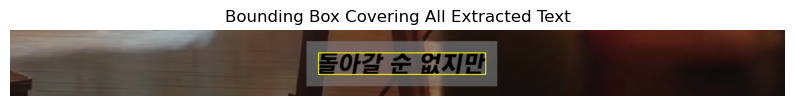

In [5]:
# mask == 255인 모든 좌표 추출
ys, xs = np.where(mask == 255)

# 해당 픽셀이 하나라도 존재할 경우
if len(xs) > 0 and len(ys) > 0:
    x_min, x_max = xs.min(), xs.max()
    y_min, y_max = ys.min(), ys.max()

    # 사각형 좌표 계산
    box_x, box_y = x_min, y_min
    box_w, box_h = x_max - x_min, y_max - y_min

    # 원본 crop 이미지 복사 후 박스 그리기
    boxed_image = cropped_image.copy()
    cv2.rectangle(boxed_image, (box_x, box_y), (box_x + box_w, box_y + box_h), color=(255, 255, 0), thickness=2)  # 노란색

    # 시각화
    plt.figure(figsize=(10, 5))
    plt.imshow(boxed_image)
    plt.title("Bounding Box Covering All Extracted Text")
    plt.axis('off')
    plt.show()
else:
    print("No matching pixels found in the mask.")


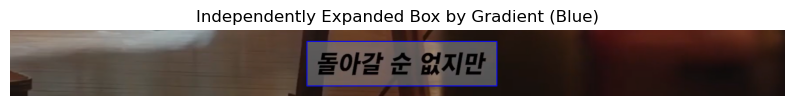

In [6]:
# Grayscale 이미지 준비
gray_crop = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2GRAY)

# 초기 bounding box (1픽셀 여유)
ys, xs = np.where(mask == 255)
x_min, x_max = xs.min() - 1, xs.max() + 1
y_min, y_max = ys.min() - 1, ys.max() + 1
box_x, box_y = x_min, y_min
box_w = x_max - x_min
box_h = y_max - y_min

# Sobel 연산으로 gradient 계산 (x, y 방향)
sobel_x = cv2.Sobel(gray_crop, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(gray_crop, cv2.CV_64F, 0, 1, ksize=3)
gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)

# 기준
max_expand = 40
gradient_threshold = 60

# 각 방향 확장 거리 초기화
expand_top = expand_bottom = expand_left = expand_right = 0

# 위쪽 확장
for i in range(1, max_expand):
    y = box_y - i
    if y < 0: break
    grad_line = gradient_magnitude[y, box_x:box_x + box_w]
    if np.mean(grad_line) >= gradient_threshold:
        expand_top = i
        break

# 아래쪽 확장
for i in range(1, max_expand):
    y = box_y + box_h + i
    if y >= gray_crop.shape[0]: break
    grad_line = gradient_magnitude[y, box_x:box_x + box_w]
    if np.mean(grad_line) >= gradient_threshold:
        expand_bottom = i
        break

# 왼쪽 확장
for i in range(1, max_expand):
    x = box_x - i
    if x < 0: break
    grad_line = gradient_magnitude[box_y:box_y + box_h, x]
    if np.mean(grad_line) >= gradient_threshold:
        expand_left = i
        break

# 오른쪽 확장
for i in range(1, max_expand):
    x = box_x + box_w + i
    if x >= gray_crop.shape[1]: break
    grad_line = gradient_magnitude[box_y:box_y + box_h, x]
    if np.mean(grad_line) >= gradient_threshold:
        expand_right = i
        break

# 최종 좌표 계산
ex1 = max(0, box_x - expand_left)
ey1 = max(0, box_y - expand_top)
ex2 = min(gray_crop.shape[1], box_x + box_w + expand_right)
ey2 = min(gray_crop.shape[0], box_y + box_h + expand_bottom)

# 시각화
final_image = cropped_image.copy()
cv2.rectangle(final_image, (ex1, ey1), (ex2, ey2), color=(0, 0, 255), thickness=2)

plt.figure(figsize=(10, 5))
plt.imshow(final_image)
plt.title("Independently Expanded Box by Gradient (Blue)")
plt.axis('off')
plt.show()
